# 70. 単語ベクトルの和による特徴量

In [6]:
import torch
import pandas as pd
import string
import re

In [34]:
df_train = pd.read_csv('./../6/data/train.txt', sep='\t')
df_valid = pd.read_csv('./../6/data/valid.txt', sep='\t')
df_test = pd.read_csv('./../6/data/test.txt', sep='\t')

In [35]:
print(df_test)

     CATEGORY                                              TITLE
0           t  UPDATE 1-US eyes bankruptcy link in GM ignitio...
1           e  17 Times Zach Braff's 'Wish I Was Here' Refere...
2           e  Orlando Bloom - Orlando Bloom wants to inspire...
3           b  Factbox: Energy Future Holdings and largest de...
4           b  UPDATE 10-Oil steadies after big drop on easin...
...       ...                                                ...
1329        t  To snap a thief: App takes 'theftie' photos an...
1330        e  Macaulay Culkin's The Pizza Underground Booed ...
1331        b  Treasury Volatility Drops on Yellen Low-Rates ...
1332        b  Shell Profit Falls 3 Percent on Lower Producti...
1333        e  Peter Mayhew - Peter Mayhew returning to Star ...

[1334 rows x 2 columns]


In [4]:
def preprocessing_text(text):
    for p in string.punctuation:
        text = text.replace(p, " ") 
    text = text.lower()
    text = re.sub('[0-9]+', '0', text)
    return text

In [36]:
df_train['TITLE'] = df_train['TITLE'].map(preprocessing_text)
df_valid['TITLE'] = df_valid['TITLE'].map(preprocessing_text)
df_test['TITLE'] = df_test['TITLE'].map(preprocessing_text)

In [37]:
print(df_test)

     CATEGORY                                              TITLE
0           t  update 0 us eyes bankruptcy link in gm ignitio...
1           e  0 times zach braff s  wish i was here  referen...
2           e  orlando bloom   orlando bloom wants to inspire...
3           b  factbox  energy future holdings and largest de...
4           b  update 0 oil steadies after big drop on easing...
...       ...                                                ...
1329        t  to snap a thief  app takes  theftie  photos an...
1330        e  macaulay culkin s the pizza underground booed ...
1331        b  treasury volatility drops on yellen low rates ...
1332        b  shell profit falls 0 percent on lower producti...
1333        e  peter mayhew   peter mayhew returning to star ...

[1334 rows x 2 columns]


In [8]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [30]:
def sentence2vec(sentence):
    words = sentence.split()
    vec = []
    for word in words:
        if word in model.key_to_index:
            vec.append(model[word])
    return torch.tensor(sum(vec)/len(vec))

In [40]:
print(sentence2vec(df_test.loc[2]['TITLE']))
print(sentence2vec(df_test.loc[2]['TITLE']).shape)

tensor([-0.0064,  0.1666,  0.0461,  0.0635, -0.0651, -0.0059,  0.1076, -0.0627,
        -0.0975,  0.0043, -0.0691, -0.1365, -0.0534,  0.0007, -0.0624,  0.1193,
         0.0442,  0.1467,  0.1217, -0.1173, -0.1886,  0.0437,  0.1072,  0.0053,
        -0.1796, -0.0396, -0.1024,  0.0732,  0.0245, -0.0174, -0.0630,  0.0473,
        -0.2296, -0.0962, -0.1084, -0.0104,  0.0239, -0.0671,  0.0096,  0.0771,
         0.1613, -0.1780,  0.1324, -0.0715, -0.0157, -0.2377, -0.0110, -0.1320,
        -0.0738,  0.0753, -0.0649,  0.0859,  0.1310,  0.1611,  0.1163,  0.0762,
        -0.0607, -0.0691, -0.0372,  0.0264,  0.1182, -0.0639, -0.0516, -0.0295,
        -0.1074, -0.0647, -0.0289,  0.0035,  0.0780,  0.0920,  0.1152,  0.0538,
        -0.0842,  0.0648, -0.1462,  0.0180,  0.0691, -0.0541, -0.0080,  0.1553,
        -0.0535,  0.0303, -0.0819, -0.1530, -0.0576,  0.1530, -0.0348,  0.0070,
        -0.0972,  0.0549,  0.0286, -0.0829, -0.1797, -0.2237, -0.0668, -0.0294,
         0.0943,  0.0873,  0.0802, -0.05

In [41]:
X_train = torch.stack([sentence2vec(title) for title in df_train['TITLE']])
X_valid = torch.stack([sentence2vec(title) for title in df_valid['TITLE']])
X_test = torch.stack([sentence2vec(title) for title in df_test['TITLE']])

In [42]:
X_train.shape

torch.Size([10672, 300])

In [43]:
category_label = {'b': 0, 't': 1, 'e':2, 'm':3}

In [54]:
y_train = torch.tensor(df_train['CATEGORY'].map(lambda x: category_label[x]))
y_valid = torch.tensor(df_valid['CATEGORY'].map(lambda x: category_label[x]))
y_test = torch.tensor(df_test['CATEGORY'].map(lambda x: category_label[x]))

In [56]:
print(y_train.shape)

torch.Size([10672])


In [57]:
torch.save(X_train, './data/X_train.pt')
torch.save(X_valid, './data/X_valid.pt')
torch.save(X_test,  './data/X_test.pt')
torch.save(y_train, './data/y_train.pt')
torch.save(y_valid, './data/y_valid.pt')
torch.save(y_test,  './data/y_test.pt')

# 71. 単層ニューラルネットワークによる予測

In [5]:
from torch import nn

/home/z44716r/miniconda3/envs/nlp100/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
X_train = torch.load('./data/X_train.pt')
X_valid = torch.load('./data/X_valid.pt')
X_test = torch.load('./data/X_test.pt')
y_train = torch.load('./data/y_train.pt')
y_valid = torch.load('./data/y_valid.pt')
y_test = torch.load('./data/y_test.pt')

In [8]:
class SP(nn.Module):
    def __init__(self):
        super().__init__()
        self.l = nn.Linear(300,4)
    def forward(self, x):
        x = self.l(x)
        return x

In [14]:
model = SP()

In [92]:
print(model)

SP(
  (l): Linear(in_features=300, out_features=4, bias=True)
)


In [15]:
logits = model.forward(X_train[0])
y_1 =  torch.softmax(logits, dim=-1)
print(logits)
print(y_1)
y_14 = torch.softmax(model.forward(X_train[:4]), dim=-1)

tensor([ 0.0998,  0.0783,  0.0521, -0.0865], grad_fn=<AddBackward0>)
tensor([0.2658, 0.2601, 0.2534, 0.2206], grad_fn=<SoftmaxBackward0>)


In [94]:
y_14

tensor([[0.2568, 0.2517, 0.2629, 0.2286],
        [0.2453, 0.2469, 0.2574, 0.2505],
        [0.2574, 0.2567, 0.2483, 0.2376],
        [0.2530, 0.2501, 0.2550, 0.2419]], grad_fn=<SoftmaxBackward0>)

# 72. 損失と勾配の計算

In [20]:
criterion = nn.CrossEntropyLoss()

In [21]:
logits = model(X_train[0])
loss = criterion(logits, y_train[0])

In [22]:
print(f'損失: {loss}')

損失: 1.3726996183395386


In [23]:
model.zero_grad()
print(f'初期化勾配：{model.l.weight.grad}')
loss.backward()
print(f'更新後勾配：{model.l.weight.grad}')

初期化勾配：tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
更新後勾配：tensor([[-0.0195, -0.0019,  0.0177,  ..., -0.0175,  0.0241,  0.0189],
        [-0.0191, -0.0018,  0.0174,  ..., -0.0171,  0.0236,  0.0185],
        [ 0.0547,  0.0053, -0.0498,  ...,  0.0492, -0.0677, -0.0530],
        [-0.0162, -0.0016,  0.0147,  ..., -0.0145,  0.0200,  0.0157]])


# 73. 確率的勾配降下法による学習

In [10]:
import torch.utils.data as data

In [13]:
class NewsDataset(data.Dataset):
    def __init__(self, X, y, phase='train'):
        self.X = X
        self.y = y
        self.phase = phase
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [14]:
train_ds = NewsDataset(X_train, y_train, phase='train')
valid_ds = NewsDataset(X_valid, y_valid, phase='val')
test_ds = NewsDataset(X_test, y_test, phase='val')

In [123]:
print(train_ds.__getitem__(0))

(tensor([-7.3273e-02, -7.0496e-03,  6.6753e-02,  6.8593e-02,  8.5124e-02,
        -7.9244e-02, -3.2888e-02, -2.3075e-01,  9.4126e-02,  6.0750e-02,
         2.7913e-02, -8.7077e-02,  3.9673e-04,  3.7638e-03,  1.7118e-02,
        -2.7059e-03,  9.9487e-03,  1.0543e-01,  1.3762e-02, -1.6479e-02,
        -4.8584e-02,  4.0927e-02,  6.1971e-02, -2.4729e-02,  6.2948e-02,
        -1.0811e-01, -2.1730e-02,  6.1198e-02,  1.0673e-01, -1.7207e-02,
         5.8484e-02,  3.3276e-02, -7.4178e-02,  3.8737e-02, -8.0037e-02,
         7.7947e-02,  1.9435e-02,  9.6232e-03,  3.3539e-02,  8.5426e-02,
        -2.1596e-02, -1.3161e-01,  1.3269e-01,  4.5644e-02,  1.0569e-01,
         6.9936e-05, -2.6754e-02, -3.2705e-02, -3.0909e-02,  6.8665e-02,
         9.3282e-03,  9.4467e-02,  8.2347e-02,  3.9958e-02,  4.2124e-02,
         6.1462e-02, -1.2727e-01, -3.9810e-02, -9.5774e-03, -1.0060e-01,
         5.3304e-02,  7.2286e-02,  1.9762e-02, -1.2910e-01,  2.4913e-02,
        -6.4936e-02, -3.1235e-02, -1.1332e-02,  2.

In [10]:
train_dataloader = data.DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dataloader = data.DataLoader(valid_ds, batch_size=len(valid_ds), shuffle=True)
test_dataloader = data.DataLoader(test_ds, batch_size=len(test_ds), shuffle=True)

In [11]:
dataloader = {'train': train_dataloader,
              'val': valid_dataloader,
              'test': test_dataloader}

In [12]:
from tqdm import tqdm

model = SP()

In [13]:
def train(model, dataloader, num_epochs):
    # 損失関数の定義
    criterion = nn.CrossEntropyLoss()
    # 最適化手法の定義
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1} / {num_epochs}')
        print('-'*50)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader[phase]):
                optimizer.zero_grad()
                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels) 
                    _, preds = torch.max(outputs, 1) 
                    # backward
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloader[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader[phase].dataset)

            
            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


In [29]:
train(model, dataloader, 20)

Epoch 1 / 20
--------------------------------------------------


  0%|          | 0/167 [00:00<?, ?it/s]

100%|██████████| 167/167 [00:00<00:00, 474.27it/s]


train Loss: 1.2765, Acc: 0.5836


100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


val Loss: 1.1934, Acc: 0.7354
Epoch 2 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1002.21it/s]


train Loss: 1.1439, Acc: 0.7413


100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


val Loss: 1.1088, Acc: 0.7466
Epoch 3 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1140.38it/s]


train Loss: 1.0784, Acc: 0.7543


100%|██████████| 1/1 [00:00<00:00, 134.13it/s]


val Loss: 1.0590, Acc: 0.7511
Epoch 4 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1131.27it/s]


train Loss: 1.0356, Acc: 0.7564


100%|██████████| 1/1 [00:00<00:00, 123.47it/s]


val Loss: 1.0230, Acc: 0.7594
Epoch 5 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1014.77it/s]


train Loss: 1.0028, Acc: 0.7594


100%|██████████| 1/1 [00:00<00:00, 121.58it/s]


val Loss: 0.9941, Acc: 0.7609
Epoch 6 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1096.24it/s]


train Loss: 0.9755, Acc: 0.7621


100%|██████████| 1/1 [00:00<00:00, 123.38it/s]


val Loss: 0.9693, Acc: 0.7631
Epoch 7 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1094.11it/s]


train Loss: 0.9517, Acc: 0.7628


100%|██████████| 1/1 [00:00<00:00, 138.86it/s]


val Loss: 0.9475, Acc: 0.7654
Epoch 8 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1071.71it/s]


train Loss: 0.9307, Acc: 0.7636


100%|██████████| 1/1 [00:00<00:00, 132.98it/s]


val Loss: 0.9280, Acc: 0.7661
Epoch 9 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1081.43it/s]


train Loss: 0.9117, Acc: 0.7640


100%|██████████| 1/1 [00:00<00:00, 133.96it/s]


val Loss: 0.9103, Acc: 0.7669
Epoch 10 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1129.46it/s]


train Loss: 0.8944, Acc: 0.7648


100%|██████████| 1/1 [00:00<00:00, 133.87it/s]


val Loss: 0.8941, Acc: 0.7684
Epoch 11 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1145.75it/s]


train Loss: 0.8786, Acc: 0.7654


100%|██████████| 1/1 [00:00<00:00, 133.75it/s]


val Loss: 0.8792, Acc: 0.7684
Epoch 12 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1146.40it/s]


train Loss: 0.8640, Acc: 0.7658


100%|██████████| 1/1 [00:00<00:00, 135.09it/s]


val Loss: 0.8655, Acc: 0.7676
Epoch 13 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1116.36it/s]


train Loss: 0.8505, Acc: 0.7656


100%|██████████| 1/1 [00:00<00:00, 131.64it/s]


val Loss: 0.8528, Acc: 0.7676
Epoch 14 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1157.30it/s]


train Loss: 0.8379, Acc: 0.7660


100%|██████████| 1/1 [00:00<00:00, 135.94it/s]


val Loss: 0.8409, Acc: 0.7684
Epoch 15 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1171.43it/s]


train Loss: 0.8262, Acc: 0.7662


100%|██████████| 1/1 [00:00<00:00, 136.16it/s]


val Loss: 0.8299, Acc: 0.7691
Epoch 16 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1165.92it/s]


train Loss: 0.8152, Acc: 0.7662


100%|██████████| 1/1 [00:00<00:00, 136.56it/s]


val Loss: 0.8195, Acc: 0.7699
Epoch 17 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1161.05it/s]


train Loss: 0.8049, Acc: 0.7665


100%|██████████| 1/1 [00:00<00:00, 135.71it/s]


val Loss: 0.8097, Acc: 0.7706
Epoch 18 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1133.67it/s]


train Loss: 0.7952, Acc: 0.7670


100%|██████████| 1/1 [00:00<00:00, 130.68it/s]


val Loss: 0.8005, Acc: 0.7714
Epoch 19 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1124.99it/s]


train Loss: 0.7861, Acc: 0.7671


100%|██████████| 1/1 [00:00<00:00, 134.67it/s]


val Loss: 0.7918, Acc: 0.7721
Epoch 20 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1128.30it/s]


train Loss: 0.7774, Acc: 0.7680


100%|██████████| 1/1 [00:00<00:00, 120.44it/s]

val Loss: 0.7835, Acc: 0.7729


In [36]:
torch.save(model.state_dict(), './data/news.model')

# 74. 正解率の計測

In [33]:
def calc_acc(model, dataloader):
    model.eval()
    corrects = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) # ラベルを予想
            corrects += torch.sum(preds == labels.data)
    return corrects / len(dataloader.dataset)

In [34]:
acc_train = calc_acc(model, dataloader['train'])
acc_valid = calc_acc(model, dataloader['val'])
acc_test = calc_acc(model, dataloader['test'])

In [35]:
print(f'train acuracy: {acc_train}')
print(f'valid acuracy: {acc_valid}')
print(f'test acuracy: {acc_test}')

train acuracy: 0.7677099108695984
valid acuracy: 0.7728635668754578
test acuracy: 0.7638680934906006


In [ ]:
def train(model, dataloader, num_epochs):
    # 損失関数の定義
    criterion = nn.CrossEntropyLoss()
    # 最適化手法の定義
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1} / {num_epochs}')
        print('-'*50)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader[phase]):
                optimizer.zero_grad()
                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels) 
                    _, preds = torch.max(outputs, 1) 
                    # backward
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloader[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader[phase].dataset)
            
            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

# 75

In [ ]:
from tqdm import tqdm

model = SP()

In [14]:
def train(model, dataloader, num_epochs):
    # 損失関数の定義
    criterion = nn.CrossEntropyLoss()
    # 最適化手法の定義
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    result = {'train':{'acc':[], 'loss':[]}, 'val':{'acc':[], 'loss':[]}}
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1} / {num_epochs}')
        print('-'*50)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader[phase]):
                optimizer.zero_grad()
                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels) 
                    _, preds = torch.max(outputs, 1) 
                    # backward
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloader[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader[phase].dataset)
            result[phase]['loss'].append(epoch_loss)
            result[phase]['acc'].append(epoch_acc)
            
            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    return result

In [15]:
result = train(model, dataloader, 20)

Epoch 1 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 369.44it/s]


train Loss: 1.2782, Acc: 0.5758


100%|██████████| 1/1 [00:00<00:00, 16.97it/s]


val Loss: 1.1977, Acc: 0.7039
Epoch 2 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 994.06it/s] 


train Loss: 1.1497, Acc: 0.7364


100%|██████████| 1/1 [00:00<00:00, 14.58it/s]


val Loss: 1.1145, Acc: 0.7361
Epoch 3 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1021.78it/s]


train Loss: 1.0849, Acc: 0.7480


100%|██████████| 1/1 [00:00<00:00, 136.73it/s]


val Loss: 1.0649, Acc: 0.7549
Epoch 4 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1080.29it/s]


train Loss: 1.0418, Acc: 0.7579


100%|██████████| 1/1 [00:00<00:00, 130.93it/s]


val Loss: 1.0287, Acc: 0.7526
Epoch 5 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1067.90it/s]


train Loss: 1.0086, Acc: 0.7598


100%|██████████| 1/1 [00:00<00:00, 139.18it/s]


val Loss: 0.9992, Acc: 0.7579
Epoch 6 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1111.26it/s]


train Loss: 0.9809, Acc: 0.7621


100%|██████████| 1/1 [00:00<00:00, 138.54it/s]


val Loss: 0.9741, Acc: 0.7624
Epoch 7 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1120.21it/s]


train Loss: 0.9568, Acc: 0.7636


100%|██████████| 1/1 [00:00<00:00, 134.42it/s]


val Loss: 0.9519, Acc: 0.7654
Epoch 8 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1118.32it/s]


train Loss: 0.9353, Acc: 0.7635


100%|██████████| 1/1 [00:00<00:00, 135.05it/s]


val Loss: 0.9320, Acc: 0.7661
Epoch 9 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1123.04it/s]


train Loss: 0.9161, Acc: 0.7634


100%|██████████| 1/1 [00:00<00:00, 132.58it/s]


val Loss: 0.9140, Acc: 0.7684
Epoch 10 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1101.67it/s]


train Loss: 0.8985, Acc: 0.7643


100%|██████████| 1/1 [00:00<00:00, 139.15it/s]


val Loss: 0.8976, Acc: 0.7684
Epoch 11 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1121.66it/s]


train Loss: 0.8825, Acc: 0.7642


100%|██████████| 1/1 [00:00<00:00, 134.77it/s]


val Loss: 0.8825, Acc: 0.7684
Epoch 12 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1118.88it/s]


train Loss: 0.8677, Acc: 0.7649


100%|██████████| 1/1 [00:00<00:00, 139.38it/s]


val Loss: 0.8686, Acc: 0.7699
Epoch 13 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1085.81it/s]


train Loss: 0.8540, Acc: 0.7648


100%|██████████| 1/1 [00:00<00:00, 130.92it/s]


val Loss: 0.8556, Acc: 0.7691
Epoch 14 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1119.68it/s]


train Loss: 0.8413, Acc: 0.7655


100%|██████████| 1/1 [00:00<00:00, 134.30it/s]


val Loss: 0.8436, Acc: 0.7691
Epoch 15 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1123.59it/s]


train Loss: 0.8294, Acc: 0.7660


100%|██████████| 1/1 [00:00<00:00, 142.45it/s]


val Loss: 0.8324, Acc: 0.7699
Epoch 16 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1122.62it/s]


train Loss: 0.8183, Acc: 0.7658


100%|██████████| 1/1 [00:00<00:00, 128.51it/s]


val Loss: 0.8219, Acc: 0.7721
Epoch 17 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1121.30it/s]


train Loss: 0.8079, Acc: 0.7665


100%|██████████| 1/1 [00:00<00:00, 139.37it/s]


val Loss: 0.8120, Acc: 0.7699
Epoch 18 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1121.74it/s]


train Loss: 0.7980, Acc: 0.7667


100%|██████████| 1/1 [00:00<00:00, 137.00it/s]


val Loss: 0.8026, Acc: 0.7699
Epoch 19 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1092.74it/s]


train Loss: 0.7888, Acc: 0.7673


100%|██████████| 1/1 [00:00<00:00, 126.83it/s]


val Loss: 0.7938, Acc: 0.7706
Epoch 20 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1122.15it/s]


train Loss: 0.7800, Acc: 0.7674


100%|██████████| 1/1 [00:00<00:00, 138.73it/s]

val Loss: 0.7854, Acc: 0.7706


In [19]:
result

{'train': {'acc': [tensor(0.5758, dtype=torch.float64),
   tensor(0.7364, dtype=torch.float64),
   tensor(0.7480, dtype=torch.float64),
   tensor(0.7579, dtype=torch.float64),
   tensor(0.7598, dtype=torch.float64),
   tensor(0.7621, dtype=torch.float64),
   tensor(0.7636, dtype=torch.float64),
   tensor(0.7635, dtype=torch.float64),
   tensor(0.7634, dtype=torch.float64),
   tensor(0.7643, dtype=torch.float64),
   tensor(0.7642, dtype=torch.float64),
   tensor(0.7649, dtype=torch.float64),
   tensor(0.7648, dtype=torch.float64),
   tensor(0.7655, dtype=torch.float64),
   tensor(0.7660, dtype=torch.float64),
   tensor(0.7658, dtype=torch.float64),
   tensor(0.7665, dtype=torch.float64),
   tensor(0.7667, dtype=torch.float64),
   tensor(0.7673, dtype=torch.float64),
   tensor(0.7674, dtype=torch.float64)],
  'loss': [1.278165965959586,
   1.1496944159403377,
   1.0848610006172261,
   1.0418442196395623,
   1.0086278180847283,
   0.980885975721894,
   0.9567667125225782,
   0.93533984304

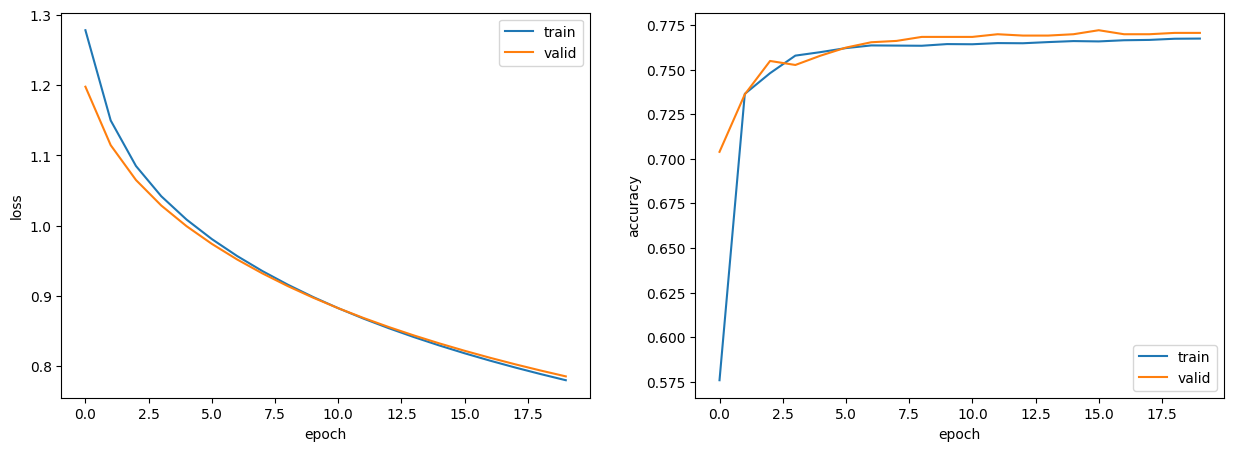

In [23]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(result['train']["loss"], label='train')
ax[0].plot(result['val']["loss"], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(result['train']['acc'], label='train')
ax[1].plot(result['val']['acc'], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

# 76

In [24]:
from tqdm import tqdm

model = SP()

In [25]:
def train(model, dataloader, num_epochs):
    # 損失関数の定義
    criterion = nn.CrossEntropyLoss()
    # 最適化手法の定義
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    result = {'train':{'acc':[], 'loss':[]}, 'val':{'acc':[], 'loss':[]}}
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1} / {num_epochs}')
        print('-'*50)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader[phase]):
                optimizer.zero_grad()
                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels) 
                    _, preds = torch.max(outputs, 1) 
                    # backward
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloader[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader[phase].dataset)
            result[phase]['loss'].append(epoch_loss)
            result[phase]['acc'].append(epoch_acc)
            
            # チェックポイントの保存
            torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'model/checkpoint{epoch + 1}.pt')

            
            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    return result

In [26]:
result = train(model, dataloader, 20)

Epoch 1 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1019.16it/s]


train Loss: 1.2801, Acc: 0.6375


100%|██████████| 1/1 [00:00<00:00, 114.39it/s]


val Loss: 1.1932, Acc: 0.7301
Epoch 2 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1125.05it/s]


train Loss: 1.1423, Acc: 0.7353


100%|██████████| 1/1 [00:00<00:00, 127.57it/s]


val Loss: 1.1061, Acc: 0.7459
Epoch 3 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1125.08it/s]


train Loss: 1.0760, Acc: 0.7498


100%|██████████| 1/1 [00:00<00:00, 143.95it/s]


val Loss: 1.0564, Acc: 0.7526
Epoch 4 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1125.29it/s]


train Loss: 1.0332, Acc: 0.7571


100%|██████████| 1/1 [00:00<00:00, 138.17it/s]


val Loss: 1.0206, Acc: 0.7564
Epoch 5 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1127.39it/s]


train Loss: 1.0006, Acc: 0.7614


100%|██████████| 1/1 [00:00<00:00, 141.44it/s]


val Loss: 0.9919, Acc: 0.7586
Epoch 6 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1124.56it/s]


train Loss: 0.9736, Acc: 0.7621


100%|██████████| 1/1 [00:00<00:00, 141.71it/s]


val Loss: 0.9674, Acc: 0.7601
Epoch 7 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1106.97it/s]


train Loss: 0.9502, Acc: 0.7634


100%|██████████| 1/1 [00:00<00:00, 135.88it/s]


val Loss: 0.9459, Acc: 0.7616
Epoch 8 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1108.80it/s]


train Loss: 0.9294, Acc: 0.7641


100%|██████████| 1/1 [00:00<00:00, 140.90it/s]


val Loss: 0.9267, Acc: 0.7646
Epoch 9 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1113.87it/s]


train Loss: 0.9107, Acc: 0.7650


100%|██████████| 1/1 [00:00<00:00, 138.45it/s]


val Loss: 0.9092, Acc: 0.7646
Epoch 10 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1107.26it/s]


train Loss: 0.8936, Acc: 0.7653


100%|██████████| 1/1 [00:00<00:00, 143.89it/s]


val Loss: 0.8932, Acc: 0.7654
Epoch 11 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1112.80it/s]


train Loss: 0.8780, Acc: 0.7657


100%|██████████| 1/1 [00:00<00:00, 136.50it/s]


val Loss: 0.8785, Acc: 0.7669
Epoch 12 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1114.48it/s]


train Loss: 0.8636, Acc: 0.7656


100%|██████████| 1/1 [00:00<00:00, 135.85it/s]


val Loss: 0.8650, Acc: 0.7676
Epoch 13 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1088.25it/s]


train Loss: 0.8502, Acc: 0.7660


100%|██████████| 1/1 [00:00<00:00, 141.93it/s]


val Loss: 0.8524, Acc: 0.7676
Epoch 14 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1109.04it/s]


train Loss: 0.8378, Acc: 0.7664


100%|██████████| 1/1 [00:00<00:00, 118.68it/s]


val Loss: 0.8406, Acc: 0.7676
Epoch 15 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1061.70it/s]


train Loss: 0.8262, Acc: 0.7669


100%|██████████| 1/1 [00:00<00:00, 142.66it/s]


val Loss: 0.8296, Acc: 0.7684
Epoch 16 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1075.43it/s]


train Loss: 0.8153, Acc: 0.7669


100%|██████████| 1/1 [00:00<00:00, 137.06it/s]


val Loss: 0.8193, Acc: 0.7691
Epoch 17 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1102.80it/s]


train Loss: 0.8050, Acc: 0.7669


100%|██████████| 1/1 [00:00<00:00, 139.17it/s]


val Loss: 0.8096, Acc: 0.7699
Epoch 18 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1125.41it/s]


train Loss: 0.7954, Acc: 0.7673


100%|██████████| 1/1 [00:00<00:00, 150.19it/s]


val Loss: 0.8004, Acc: 0.7699
Epoch 19 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1111.02it/s]


train Loss: 0.7863, Acc: 0.7677


100%|██████████| 1/1 [00:00<00:00,  9.61it/s]


val Loss: 0.7918, Acc: 0.7714
Epoch 20 / 20
--------------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 1098.22it/s]


train Loss: 0.7776, Acc: 0.7680


100%|██████████| 1/1 [00:00<00:00, 137.15it/s]

val Loss: 0.7836, Acc: 0.7714


# 77

In [29]:
from tqdm import tqdm

model = SP()

In [24]:
import time
def train(model, dataloader, num_epochs):
    # 損失関数の定義
    criterion = nn.CrossEntropyLoss()
    # 最適化手法の定義
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    result = {'train':{'acc':[], 'loss':[]}, 'val':{'acc':[], 'loss':[]}}
    for epoch in range(num_epochs):
        start = time.time()
        print(f'Epoch {epoch+1} / {num_epochs}')
        print('-'*50)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader[phase]):
                optimizer.zero_grad()
                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels) 
                    _, preds = torch.max(outputs, 1) 
                    # backward
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloader[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader[phase].dataset)
            result[phase]['loss'].append(epoch_loss)
            result[phase]['acc'].append(epoch_acc)
            
        end = time.time()    
        print(f'Loss: {epoch_loss}, Acc: {epoch_acc}, Time: {end-start:.4f}')

In [25]:
def batch_train(model, bs, num_epochs):

    train_dataloader = data.DataLoader(train_ds, batch_size=bs, shuffle=True)
    valid_dataloader = data.DataLoader(valid_ds, batch_size=len(valid_ds), shuffle=True)
    test_dataloader = data.DataLoader(test_ds, batch_size=len(test_ds), shuffle=True)

    dataloader = {'train': train_dataloader,
                'val': valid_dataloader,
                'test': test_dataloader}
    print(f'bs: {bs}')
    train(model, dataloader, num_epochs)


In [35]:
for bs in [2**i for i in range(11)]:
    model = SP()
    batch_train(model, bs, 1)

bs: 1
Epoch 1 / 1
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 110.72it/s]


Loss: 0.6058570146560669, Acc: 0.7931034482758621, Time: 3.6201
bs: 2
Epoch 1 / 1
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 115.95it/s]


Loss: 0.7095074653625488, Acc: 0.7736131934032984, Time: 2.4888
bs: 4
Epoch 1 / 1
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 123.83it/s]


Loss: 0.820781946182251, Acc: 0.7691154422788605, Time: 1.2610
bs: 8
Epoch 1 / 1
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 108.47it/s]


Loss: 0.9246547818183899, Acc: 0.7713643178410795, Time: 0.6645
bs: 16
Epoch 1 / 1
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 122.79it/s]


Loss: 1.0258029699325562, Acc: 0.7593703148425787, Time: 0.3885
bs: 32
Epoch 1 / 1
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 116.96it/s]


Loss: 1.1034893989562988, Acc: 0.7511244377811095, Time: 0.2484
bs: 64
Epoch 1 / 1
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 126.93it/s]


Loss: 1.18662428855896, Acc: 0.7076461769115442, Time: 0.1743
bs: 128
Epoch 1 / 1
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 127.54it/s]


Loss: 1.261855959892273, Acc: 0.6041979010494752, Time: 0.1223
bs: 256
Epoch 1 / 1
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 120.15it/s]


Loss: 1.3307803869247437, Acc: 0.5134932533733133, Time: 0.1015
bs: 512
Epoch 1 / 1
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 127.53it/s]


Loss: 1.3668524026870728, Acc: 0.4325337331334333, Time: 0.1237
bs: 1024
Epoch 1 / 1
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 126.63it/s]

Loss: 1.3749229907989502, Acc: 0.3733133433283358, Time: 0.0783


# 78

In [21]:
import time
from tqdm import tqdm
def train(model, dataloader, num_epochs):
    model.to('cuda')
    # 損失関数の定義
    criterion = nn.CrossEntropyLoss()
    # 最適化手法の定義
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    result = {'train':{'acc':[], 'loss':[]}, 'val':{'acc':[], 'loss':[]}}
    for epoch in range(num_epochs):
        start = time.time()
        print(f'Epoch {epoch+1} / {num_epochs}')
        print('-'*50)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader[phase]):
    
                optimizer.zero_grad()
                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.to('cuda'))
                    loss = criterion(outputs, labels.to('cuda')) 
                    _, preds = torch.max(outputs, 1) 
                    # backward
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.to('cuda').data)
            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloader[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader[phase].dataset)
            result[phase]['loss'].append(epoch_loss)
            result[phase]['acc'].append(epoch_acc)
            
        end = time.time()    
        print(f'Loss: {epoch_loss}, Acc: {epoch_acc}, Time: {end-start:.4f}')

In [17]:
def batch_train(model, bs, num_epochs):

    train_dataloader = data.DataLoader(train_ds, batch_size=bs, shuffle=True)
    valid_dataloader = data.DataLoader(valid_ds, batch_size=len(valid_ds), shuffle=True)
    test_dataloader = data.DataLoader(test_ds, batch_size=len(test_ds), shuffle=True)

    dataloader = {'train': train_dataloader,
                'val': valid_dataloader,
                'test': test_dataloader}
    print(f'bs: {bs}')
    train(model, dataloader, num_epochs)


In [22]:
for bs in [2**i for i in range(11)]:
    model = SP()
    batch_train(model, bs, 1)

bs: 1
Epoch 1 / 1
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 40.69it/s]


Loss: 0.6070857048034668, Acc: 0.787856071964018, Time: 6.5718
bs: 2
Epoch 1 / 1
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 118.07it/s]


Loss: 0.7101367712020874, Acc: 0.7728635682158921, Time: 3.2006
bs: 4
Epoch 1 / 1
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 132.92it/s]


Loss: 0.8217602968215942, Acc: 0.7691154422788605, Time: 1.6319
bs: 8
Epoch 1 / 1
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 124.48it/s]


Loss: 0.9309073686599731, Acc: 0.7683658170914542, Time: 0.8389
bs: 16
Epoch 1 / 1
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 133.44it/s]


Loss: 1.020029902458191, Acc: 0.7638680659670165, Time: 0.4553
bs: 32
Epoch 1 / 1
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 135.43it/s]


Loss: 1.0955619812011719, Acc: 0.7391304347826086, Time: 0.2510
bs: 64
Epoch 1 / 1
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 116.82it/s]


Loss: 1.1842561960220337, Acc: 0.7481259370314842, Time: 0.1640
bs: 128
Epoch 1 / 1
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 127.53it/s]


Loss: 1.2618955373764038, Acc: 0.6619190404797601, Time: 0.1236
bs: 256
Epoch 1 / 1
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 127.44it/s]


Loss: 1.305203914642334, Acc: 0.45727136431784104, Time: 0.0955
bs: 512
Epoch 1 / 1
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 135.04it/s]


Loss: 1.3436200618743896, Acc: 0.4010494752623688, Time: 0.0772
bs: 1024
Epoch 1 / 1
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 139.76it/s]

Loss: 1.370417594909668, Acc: 0.46326836581709147, Time: 0.2153


# 79

In [23]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(300,256)
        self.l2 = nn.Linear(256,4)
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        return x

In [27]:
model = MLP()
batch_train(model, 64, 20)

bs: 64
Epoch 1 / 20
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 75.71it/s]


Loss: 1.1774238348007202, Acc: 0.6671664167916042, Time: 0.2993
Epoch 2 / 20
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 105.42it/s]


Loss: 1.1063263416290283, Acc: 0.7428785607196402, Time: 0.2973
Epoch 3 / 20
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 61.28it/s]


Loss: 1.0564959049224854, Acc: 0.7533733133433284, Time: 0.2540
Epoch 4 / 20
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 94.07it/s]


Loss: 1.0038681030273438, Acc: 0.7578710644677661, Time: 0.2414
Epoch 5 / 20
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 111.42it/s]


Loss: 0.946979820728302, Acc: 0.7593703148425787, Time: 0.2393
Epoch 6 / 20
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 105.19it/s]


Loss: 0.8907342553138733, Acc: 0.7661169415292354, Time: 0.2725
Epoch 7 / 20
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 88.83it/s]


Loss: 0.8399379849433899, Acc: 0.7668665667166417, Time: 0.2748
Epoch 8 / 20
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 122.47it/s]


Loss: 0.796894371509552, Acc: 0.7668665667166417, Time: 0.2329
Epoch 9 / 20
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 120.54it/s]


Loss: 0.7615709900856018, Acc: 0.7706146926536732, Time: 0.2312
Epoch 10 / 20
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 118.10it/s]


Loss: 0.7325827479362488, Acc: 0.7713643178410795, Time: 0.2739
Epoch 11 / 20
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 118.66it/s]


Loss: 0.7087820768356323, Acc: 0.7721139430284858, Time: 0.2398
Epoch 12 / 20
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 117.71it/s]


Loss: 0.6888009309768677, Acc: 0.7736131934032984, Time: 0.2387
Epoch 13 / 20
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 111.99it/s]


Loss: 0.6719695925712585, Acc: 0.775112443778111, Time: 0.2248
Epoch 14 / 20
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


Loss: 0.6571815609931946, Acc: 0.7773613193403298, Time: 0.3425
Epoch 15 / 20
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 123.62it/s]


Loss: 0.6442015171051025, Acc: 0.7788605697151424, Time: 0.2451
Epoch 16 / 20
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 103.44it/s]


Loss: 0.6326504349708557, Acc: 0.7781109445277361, Time: 0.2488
Epoch 17 / 20
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 110.99it/s]


Loss: 0.6222600340843201, Acc: 0.7788605697151424, Time: 0.2525
Epoch 18 / 20
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 108.36it/s]


Loss: 0.6126174330711365, Acc: 0.7796101949025487, Time: 0.2618
Epoch 19 / 20
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 127.41it/s]


Loss: 0.6037106513977051, Acc: 0.780359820089955, Time: 0.2498
Epoch 20 / 20
--------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 118.92it/s]

Loss: 0.5951867699623108, Acc: 0.7811094452773614, Time: 0.2341
